# Whose Line Is It Anyway?
Given a sentence from a State of the Nation address, can we correctly predict which president said it?

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing import sequence
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Activation, Bidirectional, RepeatVector, Input
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

## Reading In and Overview of Data

The data that is read in using the terminal lines above has been through some rigorous pre-processing. The resulting dataset consists of rows of individual sentences in a column called **'text'**, with a corresponding integer value between 0 and 5 in the **'labels'** column which refers to the president who spoke that sentence.

The label-to-president mapping is as follows:

- 0: De Klerk
- 1: Mandela
- 2: Mbeki
- 3: Motlanthe
- 4: Zuma
- 5: Ramaphosa

In [0]:
# read text data
df = pd.read_csv('https://raw.githubusercontent.com/James-Leslie/president-speech-classifier/master/data/model_input.csv')

In [144]:
# show some of the data
df.head(5)

,labels,text
0,0,mr speaker
1,0,this parliament has convened to adopt importan...
2,0,the fact that we have done so in the midst of ...
3,0,it is an indication of the importance which w...
4,0,if we wish to have a peaceful and stable futur...


### Number of Lines of Text per President

After the pre-processing, each row of the dataset contains roughly one sentence as spoken by a president. We take a look at the distribution of sentences per president to get an idea of the inherent class balances (or imbalances).

In [145]:
df['labels'].value_counts()

4    3145
2    3074
1    1785
3     306
5     275
0     105
Name: labels, dtype: int64

Evidently, Zuma and Mbeki have by far the majority of sentences. There is a serious class imbalance, one which calls for some class rebalancing before any classification model is trained. We will revisit the class imbalance problem in a little while, but first we'll need to split the data into train and test sets.

## Train/Test Split

It is important that before we do any class balancing, the data be split into train and test sets. The reason for this is that if we decided to use some method of resampling data from the minority classes in order to simulate a more balanced distribution, and only then split it into train and test sets, we might see duplicates of some observations appearing in both the train and test sets.

Clearly, this will affect the performance of the model: if it is trained on an observation and then shown that observation again during validation, we are not performing a true test of unseen data. The model will have learnt by heart what to classify that observation as.

We make use of the **`train_test_split`** function from **`scikitlearn`**.

In [0]:
from sklearn.model_selection import train_test_split

train, test, _, _ = train_test_split(df[['labels', 'text']],
                                     df['labels'],
                                     test_size=0.15,
                                     random_state=85)

## Class Imbalance

There are various means to balance classes for classification problems. One of those means is to downsample the majority class, ie, when creating training data for the model, feed it some subset of all the observations in the majority class. The problem with this method is that you tend to throw away valuable data in the observations that are not sampled.

A nice alternative is upsampling the minority class, ie, repeating some observations from that class to simulate a greater dataset. The problem with this method is that the model tends to overfit to the training data as it is fed duplicate observations during training.

A third method is to create new, synthetic observations based on the observations that exist in the minority class. One way to do this is with k-nearest neighbours: find, say, the 3 nearest neighbours to some point in the featurespace, and generate a new point based on the average of those 3 others. This is typically a more trivial problem when the features are all numeric. However, this is tricky to do with text data while still maintaining the order and adjacency of words in sequence.

As such, we developed a synthetic text data generator of our own. The basic process of the synthetic data generation is as follows:

1.  Using term frequency-inverse document frequency, create a frequency matrix of n-grams from the sentences in the minority class, where n is a specified as a range of integers by the modeller.
2. Create a list of relative frequencies of these n-grams by summing the rows of the frequency matrix in a column-wise fashion.
3. Divide this list by the sum of the list. This effectively turns the list of frequencies into a list of probabilities with which each n-gram appears in in the sentence data.
4. Retrieve the list of n-grams from the column names of the frequency table.
5. We now have a list of n-grams, or mini-sentences, and a corresponding list of the probabilities of finding each of those n-grams in the original text data.
6. We then loop a user-specified number of times - this value should correspond with the number of new sentences required.
7. Within each cycle, we randomly sample, without replacement, three n-grams from the list in step 5. These three n-grams are concatenated to form a new term.
7. These terms are the new sentences, and we append them to the original data. The number of samples is an argument to be specified by the modeller, and should be chosen such that the total of synthetic and original observations roughly equals the number of observations in the majority class.

### Possible Problems with this Approach

It did occur to us during the design of this class balancing method that when concatenating various n-grams, any two n-grams placed adjacent to one another would create a bi-gram at the interface of these two n-grams.

We decided that an important validation to implement given more time to work on the project, would be to check the bi-gram created at the interface of two n-grams against a list of all existing bi-grams in the corpus. Reason being, it would be important to ensure that we are not placing words next to each other that the president in question has never actually said, and would not be likely to ever say.

We stopped short of implementing a validation like this, because we decided that even if the new bi-gram did exist elsewhere in the corpus, the second-last word in the first n-gram, and the second word in the second n-gram would also contribute to new tri- and quad-grams, and so on and so forth. Recursively checking each of these to see if they exist in the corpus would be very slow, and probably limit the volume of synthetic data we would be able to generate.

In [0]:
def synthesize(original, target, n_gram_range):
    
    # create the tfidf vectoriser object
    tvec = TfidfVectorizer(stop_words='english',
                           ngram_range=n_gram_range,
                           token_pattern = r'(?u)\S\S+')
    
    # fit the tfidf vectoriser object to the sentence data for deKlerk
    tfidf = tvec.fit_transform(original['text'])
    
    # create dataframe of all n-grams and their weightings
    grams = pd.DataFrame(tfidf.todense(), columns=tvec.get_feature_names())
    
    # sum the dataframe column-wise and divide by the sum of the resulting row
    # this gives a vector of weights which sum to 1
    probs = grams.sum(axis=0)/sum(grams.sum(axis=0))
    
    # vector of n-grams from which to sample
    terms = list(tvec.get_feature_names())
    
    # empty vector for new sentence data
    new_list = []
    
    # create loop to run target number of times and concatenate 3 n-grams
    for i in range(target):
      # randomly find 3 different n-grams
      three_n_grams = np.random.choice(terms, 3, replace=False, p=probs)
      
      # create single sentence using three terms together
      new_term = ' '.join(three_n_grams)
      
      new_list.append(new_term)
      
    
    
    # set labels column of new data equal to that of input
    new_list = pd.DataFrame(new_list, columns=['text'])
    
    new_list['labels'] = original['labels'].values[0]
    
    return new_list

### History of Class Balancing Within This Project

Prior to implementing the method of upsampling using synthetic data as detailed above, we trialled two other alternative methods of balancing the classes.

#### Library: imbalanced-learn

The first made use of a Python library by the name of **`imbalanced-learn`**, which contains methods to do various types of up- and down-sampling for your dataset.

For reasons detailed above, we did not bother to do standard up- and down-sampling of minority and majority classes, respectively. `imblearn` does, however, contain a method called `smote` (Synthetic Minority Oversampling Technique), which uses k-nearest neighbours to create new observations based on existing observations within the feature space. The issue with this approach and with the `imblearn` library in general was that it required data to be vectorised before it could be meddled with. In the context of our speech data, this meant creating a bag of words model where each word's occurence in a sentence/document is represented by a number in a sparse matrix.

Clearly, vectorising a sentence absents the order and adjacency inherent in that sentence, which we thought would be very important in helping a model determine patterns in speech. As such, we could not use any of the methods in the `imblearn` library.

#### Synthesizing Basic Sentences

The next thing we tried was the basis for the `synthesize` function in the code block above. The basic outline of the process was as follows:

1. Generate a list of n-grams from the text data. The n-value is a range specified by the user.
2. Sum the frequency of each n-gram for all documents to obtain overall frequency in the corpus.
3. Randomly sample from the list of n-grams, in the proportion that they occur in the corpus. i.e.: using as the sampling distribution the frequencies summed in step 2.
4. Each n-gram sampled is now a new sentence that is appended to the original dataset.

This process produced a list of terms of a few words each which were all exceprts of sentences said by the president in question. It was an effective way of generating data for the minority classes without the risk of having duplicate observations. It was a natural extension of this idea to concatenate multiple of these n-grams into a new sentence, which is what we ultimately included in the model, above.

#### Classification Results

To our dismay, there appeared to be no synthetic data generation that we could do with any of these methods which improved the test accuracy of our neural network classifier.

Recall that we carry out the train/test split _before_ synthesizing new data. This is important to ensure the test set contains only original sentences as spoken by the president. We would then carry out synthetic data generation using the training set only, and go on to train the model with that part-original, part-synthetic data.

What we found was that regardless of the size of the n-grams selected by the user for the synthetic data, and regardless of the model architecture, and regardless of whether the classes were balanced or not, the test accuracy would not exceed around 61%. Initially it was baffling, but the conclusion that Kieran has come to is that the two classes with the most observations, Zuma and Mbeki, tend to dominate the accuracy of the model.

In other words, because the sentences by Zuma and Mbeki make up around 70% of the total sentences in the data set, the model appeared to be getting an accuracy of up to 80% for these two classes, with the remainder of the accuracy coming from a handful of correct classifications in the other four classes.

An intuitive conclusion would be to say that the synthetic data generation made zero difference, but we believe it more likely to be the fact that there is so little data for the minority classes like deKlerk and Ramaphosa, that the variety in their sentences was not significant enough anyway. They simply did not have enough unique sentences or phrases to be classified correctly and repeatedly.

We now have a function which can be called to generate new synthetic data for minority classes for the purposes of balancing them with the majority ones. We may as well bring the number of observations in all the classes to match the number in the most common class.

After splitting into train and test sets, the distribitions are as follows:

Text(0.5,1,'Observations per Class')

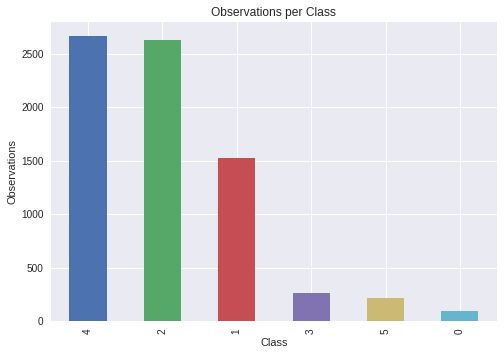

In [148]:
train['labels'].value_counts().plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Observations')
plt.title('Observations per Class')

Clearly, we'll need to bring up the number of samples for all the classes except that with label 4 (Zuma). In order to do that we create separate datasets containing the training observations for each president.

In [0]:
# create separate training sets for each of the unbalanced classes
fwdk_train = train[train['labels']==0]
mand_train = train[train['labels']==1]
mbe_train = train[train['labels']==2]
km_train = train[train['labels']==3]
cr_train = train[train['labels']==5]

In [0]:
# largest class size is Zuma
class_size = train[train['labels']==4]

We then call the **`synthesize`** function we created, and pass to it the training data for a single president, the number of synthetic observations we would like to generate, and the range of n-values to be used for n-grams. We do this for each of the 5 presidents besides Zuma.

In [0]:
# to what size would we like to upsample?
class_size = len(train[train['labels']==4])

# run the synthesize function to generate new data for each of the presidents
fwdk_new = synthesize(fwdk_train, (class_size-len(fwdk_train))//2, (4,12))
mand_new = synthesize(mand_train, (class_size-len(mand_train))//2, (4,12))
mbe_new = synthesize(mbe_train, (class_size-len(mbe_train))//2, (4,12))
km_new = synthesize(km_train, (class_size-len(km_train))//2, (4,12))
cr_new = synthesize(cr_train, (class_size-len(fwdk_train))//2, (4,12))

Finally, we append the original training data set with the new synthetic data, and take a look at the new distributions across the classes.

In [0]:
# append all new data to main training data
train = train.append(fwdk_new).append(mand_new).append(mbe_new).append(km_new).append(cr_new)

Text(0.5,1,'Observations per Class')

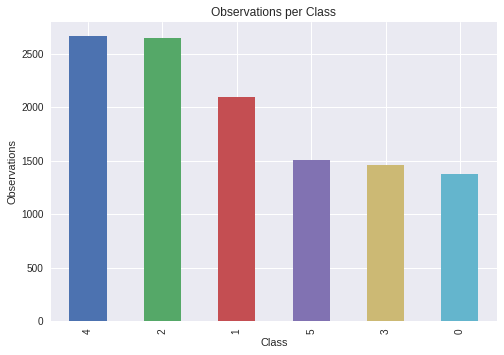

In [153]:
train['labels'].value_counts().plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Observations')
plt.title('Observations per Class')

## Word tokens
At this stage, the data is still in text format. The next step is to 'numericalize' the data.   

This process is known as tokenizing, which simply means to create a set of unique IDs to represent all of the words in the corpus.  

In Python, dictionaries make this a simple task. We will need to create a dictionary to store the mapping from words to tokens.

This can be done by creating one long array of all sentences in the corpus, and then iterating through all the words. At each consecutive word in the corpus, we will check if the word already exists in the dictionary. If the word does not exist, create an index for it. If the word is already in the dictionary, then simply skip over it.   

As an added insight, we can keep track of how frequently words appear, by adding a second 'count' value to each word's key.

![tokens](https://github.com/James-Leslie/president-speech-classifier/blob/master/data/diagrams/tokenize.png?raw=true)

In [0]:
# load whole corpus of words
all_text = df['text'].values

In [0]:
word_counts = {}

# iterate over each sentence in the corpus
for text in all_text:
  
  for word in text.split():
    
    # if the word isn't in the dictionary
    if word not in word_counts.keys():
      # create a new index for it, and add 1 to its count
      word_counts[word] = 1
    
    # if word is already in the dictionary
    else:
      # find its key, and add 1 to its count
      word_counts[word] += 1

# create mappings
stoi = {}  # string to index
itos = {}  # index to string

idx = 1

# order the words from most to least common
for word in sorted(word_counts, key=word_counts.get, reverse=True):

    if word not in stoi.keys():
      stoi[word] = idx
      itos[idx] = word
      idx += 1

In [156]:
# top 25 most common words
sorted(word_counts, key=word_counts.get, reverse=True)[:25]

['the',
 'of',
 'to',
 'and',
 'in',
 'we',
 'our',
 'that',
 'a',
 'will',
 'this',
 'as',
 'for',
 'is',
 'have',
 'with',
 'are',
 'on',
 'be',
 'all',
 'government',
 'by',
 'year',
 'it',
 'south']

In [157]:
# how many words in the corpus?
vocabulary_size = len(stoi.keys())
print(vocabulary_size)

11200


With the dictionary created, the next step is create a tokenizer. The function below performs the task of converting a string of words into an array of tokens, using the **`stoi`** dictionary created above.

In [0]:
def tokenize(string):
  
  ''' convert string to tokens '''
  
  sequence = []
  for word in string.split():
    sequence.append(stoi[word])
    
  return sequence

Similarly, we will create a function for converting from tokens back to words.

In [0]:
def untokenize(tokens):
  
  ''' convert tokens to string '''
  
  string = ' '.join(itos[token] for token in tokens)
  
  return string

#### Tokenizer example
The text data can now be numericalized, using the tokenizer.   

To illustrate the concept, an arbitrary sentence is used as an example below.

In [160]:
# view the original text data
train['text'][8189]

'we are in the midst of the first phase which is the preparatory phase which started in 2012'

In [0]:
# tokenize the training data
train['tokens'] = train['text'].apply(tokenize)

# tokenize the test data
test['tokens'] = test['text'].apply(tokenize)

In [162]:
# show the tokenized data
train['tokens'][8189].values

array([6, 17, 5, 1, 1307, 2, 1, 104, 770, 29, 14, 1, 3659, 770, 29, 472,
       5, 1125], dtype=object)

In [163]:
# convert back to text
untokenize(train['tokens'][8189])

'we are in the midst of the first phase which is the preparatory phase which started in 2012'

In [0]:
# save the tokenized data as features for training
X_train = train['tokens'].values
X_test = test['tokens'].values

## Encode category labels
Since we will be using a neural network to classify the sentences, we will need to convert the target column from a single value into a one-hot encoded array.   

![encoding](https://github.com/James-Leslie/president-speech-classifier/blob/master/data/diagrams/encoding.png?raw=true)

In [0]:
def one_hot_encode(label):
  
  # initialize zero array
  vec = [0, 0, 0, 0, 0, 0]
  
  # set index of array corresponding to label = 1
  vec[label] = 1
  
  return vec


# save encoded labels as target for model
y_train = np.vstack(row for row in train['labels'].apply(one_hot_encode).values)
y_test = np.vstack(row for row in test['labels'].apply(one_hot_encode).values)

Taking a look at the output below, the labels for each observation in the data are now encoded as arrays with 6 values. The position of the 1 in the array determines the class label. The vector below corresponds to de Klerk, since he is represented by a '0' in the original data. 

In [166]:
y_train[8189]

array([1, 0, 0, 0, 0, 0])

In [167]:
print('Train size:', X_train.shape)
print('Test size:', X_test.shape)

Train size: (11741,)
Test size: (1304,)


### What does the data look like now?

In [168]:
X_train

array([list([11, 10, 600, 40, 3, 93, 66, 651, 12, 247, 19, 219, 3, 48, 8, 6, 54, 3, 237, 18, 1, 1644, 318, 2, 1, 32, 4, 1194, 2, 160, 12, 73, 12, 75, 1641, 11, 281, 85, 20, 21, 91]),
       list([245, 1, 139, 2, 7, 49, 10, 93, 169, 5, 1, 414, 2, 1, 56, 2764, 6, 10, 15, 3, 209, 5902, 145, 161, 2798, 161, 9456, 2, 533, 145, 442, 597, 53, 19, 1288, 5903, 4, 9457]),
       list([226, 40, 458, 50, 2448, 3, 118, 43, 1989, 3, 474, 9, 125, 2, 880, 120, 8, 12, 649, 1284, 1372, 4042, 3011, 15, 1905, 6, 126, 16, 1, 1744, 1245, 2, 1, 90, 122, 1128, 2688, 16, 1509, 2688]),
       ...,
       list([42, 70, 1157, 780, 640, 23, 119, 2735, 2736, 515, 21, 5619, 1288, 11106, 181, 11107, 937, 5397]),
       list([259, 482, 28, 3038, 287, 5623, 388, 48, 174, 167, 392, 25, 45, 6028, 1514]),
       list([56, 2628, 469, 106, 1743, 386, 1693, 508, 490, 589, 977, 146, 250, 351, 807, 11113, 576, 69, 21, 1768, 266, 97, 1946, 499])],
      dtype=object)

In [169]:
# show a single observation
print('--token sequence')
print(X_train[325])
print('--words--')
print(untokenize(X_train[325]))
print('--label--')
print(y_train[325])

--token sequence
[24, 14, 9, 377, 3183, 3, 123, 207, 18, 11, 104, 83, 2, 1, 102, 123, 2, 1, 2562, 144, 726]
--words--
it is a great pleasure to address you on this first state of the nation address of the fifth democratic administration
--label--
[0 0 0 0 1 0]


In [170]:
print('Maximum train review length: {}'.format(
len(max(X_train, key=len))))

print('Maximum test review length: {}'.format(
len(max(X_test, key=len))))

Maximum train review length: 120
Maximum test review length: 86


### Sentence padding
Lastly, before the data can be fed into any type of machine learning model, the dimensions of each observation need to be standardized.   

In the case of a neural network, the architecture is fixed. One needs to decide beforehand, how many nodes there will be in each layer. For this reason, the sentences all need to be stretched to the same length as the longest sentence in the corpus.   

This is done by simply padding each sentence with zeros to match the length of the longest sentence.   

![padding](https://github.com/James-Leslie/president-speech-classifier/blob/master/data/diagrams/padding.png?raw=true)

In [0]:
max_words = len(max(X_train, key=len))
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

In [172]:
# example sentence
X_test[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  31,
       217,   5,   1, 104, 931, 383, 471,   2, 146,  22, 177,   1,  42,
         4, 234, 215], dtype=int32)

# Sentence Classifier
The data is now in machine-learning-ready format. The label has been one-hot encoded and all sentences have been tokenized and padded with zeros. The next step is to train some neural networks and assess their performance.

## Model 1: Simple Neural Network
To set a benchmark, the first model to be used will be a very simple, 3-layer neural network.   

This network takes the 120 token vector, feeds this through 3 hidden layers of 64, 32, and 16 units, each with ReLU activation functions and dropout, into a final output layer of 6 nodes which are squeezed by a softmax activation function.

A summary of the network is given below:

In [173]:
model_1=Sequential()
model_1.add(Dense(64, input_dim=max_words, activation='relu'))
model_1.add(Dropout(0.05))
model_1.add(Dense(32, activation='relu'))
model_1.add(Dropout(0.25))
model_1.add(Dense(16, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(6, activation='softmax'))

print(model_1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 64)                7744      
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_28 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_29 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 6)                 102       
Total para

The model is then trained for 10 epochs, with a batch size of 128, using a validation split of 30%.   

After training, the model is scored against the unseen test set.

In [174]:
batch_size = 128
num_epochs = 10

model_1.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

model_1.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.3)
scores = model_1.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model_1.metrics_names[1], scores[1]*100))

Train on 8218 samples, validate on 3523 samples
Epoch 1/10
8218/8218 [==============================] - 2s 204us/step - loss: 13.3743 - acc: 0.1533 - val_loss: 13.9057 - val_acc: 0.1354
Epoch 2/10
8218/8218 [==============================] - 1s 70us/step - loss: 12.8858 - acc: 0.1734 - val_loss: 14.0206 - val_acc: 0.1297
Epoch 3/10
8218/8218 [==============================] - 1s 69us/step - loss: 12.2539 - acc: 0.2009 - val_loss: 14.7135 - val_acc: 0.0835
Epoch 4/10
8218/8218 [==============================] - 1s 72us/step - loss: 11.6107 - acc: 0.2229 - val_loss: 14.2976 - val_acc: 0.1056
Epoch 5/10
8218/8218 [==============================] - 1s 69us/step - loss: 9.9597 - acc: 0.2574 - val_loss: 11.8386 - val_acc: 0.0749
Epoch 6/10
8218/8218 [==============================] - 1s 72us/step - loss: 6.9772 - acc: 0.2832 - val_loss: 4.9713 - val_acc: 0.0077
Epoch 7/10
8218/8218 [==============================] - 1s 69us/step - loss: 4.2678 - acc: 0.3113 - val_loss: 2.2598 - val_acc: 0.00

In [175]:
# calculate predictions
predictions_1 = model_1.predict(X_test)

pred_lbls_1 = []
for pred in predictions_1:
  pred = list(pred)
  max_value = max(pred)
  max_index = pred.index(max_value)
  pred_lbls_1.append(max_index)
  
predictions_1 = np.array(pred_lbls_1)

y_lbls = []
for row in y_test:
  row = list(row)
  max_value = max(row)
  max_index = row.index(max_value)
  y_lbls.append(max_index)
  
y_lbls = np.array(y_lbls)

from sklearn.metrics import confusion_matrix

cm_1 = confusion_matrix(y_lbls, predictions_1)

pd.DataFrame(cm_1)

,0,1,2,3,4,5
0,0,0,0,0,13,0
1,0,0,0,0,262,0
2,0,0,0,0,449,0
3,0,0,0,0,40,0
4,0,0,0,0,483,0
5,0,0,0,0,57,0


Taking a look at the confusion matrix above, the model is simply picking the majority class for every observation in the test set.   

Now we will take a look at some other types of neural networks which might be better suited to the job.   

NOTE: for each of the models shown below, a number of different architectures were trialled. The architectures shown below were those which performed the best. Of course, there is an almost infinite number of feasible architectures, and the process of model building comes down to a large amount of trial and error.

## Model 2: Recurrent Neural Network (RNN) with embeddings
In an attempt to improve on the basic network, a recurrent neural network was attempted next. RNNs have shown themselves to be useful for the task of learning sequential data. They have been very well-used with time series data, but have also been very successfully used for NLP tasks.   

Since sentences have order (you cannot simply swap two words around in a sentence, unlike in a data set like the Boston houses where the order of columns doesn't matter), we need to use a network which is capable of learning these patterns in data.   

### Embeddings
In addition to the LSTM cell in the network, an embedding layer is used at the first layer as a way of learning semantic meaning of words, based on the context in which they will often appear.

In [203]:
embedding_size=64

model_2=Sequential()
model_2.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model_2.add(Dropout(0.05))
model_2.add(Bidirectional(LSTM(64, activation='tanh')))
model_2.add(Dropout(0.15))
model_2.add(Dense(6, activation='softmax'))

print(model_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 120, 64)           716800    
_________________________________________________________________
dropout_51 (Dropout)         (None, 120, 64)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               66048     
_________________________________________________________________
dropout_52 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 6)                 774       
Total params: 783,622
Trainable params: 783,622
Non-trainable params: 0
_________________________________________________________________
None


In [204]:
batch_size = 256
num_epochs = 10

model_2.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

model_2.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.3)
scores = model_2.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model_2.metrics_names[1], scores[1]*100))

Train on 8218 samples, validate on 3523 samples
Epoch 1/10
8218/8218 [==============================] - 29s 3ms/step - loss: 1.5873 - acc: 0.3363 - val_loss: 2.8886 - val_acc: 0.0026
Epoch 2/10
8218/8218 [==============================] - 23s 3ms/step - loss: 1.2263 - acc: 0.5111 - val_loss: 2.4515 - val_acc: 0.1311
Epoch 3/10
8218/8218 [==============================] - 23s 3ms/step - loss: 1.0163 - acc: 0.5888 - val_loss: 2.5583 - val_acc: 0.1289
Epoch 4/10
8218/8218 [==============================] - 23s 3ms/step - loss: 0.8993 - acc: 0.6369 - val_loss: 2.4700 - val_acc: 0.1323
Epoch 5/10
8218/8218 [==============================] - 23s 3ms/step - loss: 0.7650 - acc: 0.6908 - val_loss: 2.2085 - val_acc: 0.1828
Epoch 6/10
8218/8218 [==============================] - 23s 3ms/step - loss: 0.6445 - acc: 0.7563 - val_loss: 2.0829 - val_acc: 0.2461
Epoch 7/10
8218/8218 [==============================] - 23s 3ms/step - loss: 0.5380 - acc: 0.8132 - val_loss: 2.3111 - val_acc: 0.2458
Epoch 8

In [205]:
# calculate predictions
predictions_2 = model_2.predict(X_test)

pred_lbls_2 = []
for pred in predictions_2:
  pred = list(pred)
  max_value = max(pred)
  max_index = pred.index(max_value)
  pred_lbls_2.append(max_index)
  
predictions_2 = np.array(pred_lbls_2)

cm_2 = confusion_matrix(y_lbls, predictions_2)

pd.DataFrame(cm_2)

,0,1,2,3,4,5
0,4,2,1,4,1,1
1,0,116,110,2,32,2
2,0,51,326,1,70,1
3,0,10,16,1,12,1
4,0,28,75,4,369,7
5,1,7,10,0,34,5


## Model 3: RNN with convolutional layer
Convolutional neural networks have also been used for NLP tasks, so this third model is an attempt at adding some additional complexity to the model.   

The motivation for this is that the convolutional layer, in theory, would be capable of learning n-grams that appear frequently in the data set. The kernel used below is a 1x5 window which tries to learn common combinations of words.

In [233]:
embedding_size=100
model_3=Sequential()
model_3.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model_3.add(Dropout(0.05))
model_3.add(Conv1D(64, 5, activation="relu"))
model_3.add(MaxPooling1D(pool_size=4))
model_3.add(Bidirectional(LSTM(64, activation='tanh')))
model_3.add(Dropout(0.05))
model_3.add(Dense(6, activation='softmax'))

print(model_3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 120, 100)          1120000   
_________________________________________________________________
dropout_63 (Dropout)         (None, 120, 100)          0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 116, 64)           32064     
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 29, 64)            0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 128)               66048     
_________________________________________________________________
dropout_64 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 6)                 774       
Total para

In [0]:
model_3.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [235]:
batch_size = 128
num_epochs = 10

model_3.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

model_3.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.3)
scores = model_3.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model_3.metrics_names[1], scores[1]*100))

Train on 8218 samples, validate on 3523 samples
Epoch 1/10
8218/8218 [==============================] - 18s 2ms/step - loss: 1.4135 - acc: 0.4120 - val_loss: 2.4587 - val_acc: 0.1286
Epoch 2/10
8218/8218 [==============================] - 12s 1ms/step - loss: 1.0266 - acc: 0.5863 - val_loss: 2.5334 - val_acc: 0.2044
Epoch 3/10
8218/8218 [==============================] - 12s 1ms/step - loss: 0.7744 - acc: 0.7106 - val_loss: 2.1008 - val_acc: 0.2478
Epoch 4/10
8218/8218 [==============================] - 12s 1ms/step - loss: 0.5352 - acc: 0.8132 - val_loss: 1.9195 - val_acc: 0.2833
Epoch 5/10
8218/8218 [==============================] - 12s 1ms/step - loss: 0.3801 - acc: 0.8750 - val_loss: 2.2078 - val_acc: 0.2790
Epoch 6/10
8218/8218 [==============================] - 12s 1ms/step - loss: 0.2776 - acc: 0.9112 - val_loss: 2.5337 - val_acc: 0.2796
Epoch 7/10
8218/8218 [==============================] - 12s 1ms/step - loss: 0.2169 - acc: 0.9326 - val_loss: 2.0596 - val_acc: 0.3594
Epoch 8

In [236]:
# calculate predictions
predictions_3 = model_3.predict(X_test)

pred_lbls_3 = []
for pred in predictions_3:
  pred = list(pred)
  max_value = max(pred)
  max_index = pred.index(max_value)
  pred_lbls_3.append(max_index)
  
predictions_3 = np.array(pred_lbls_3)

cm_3 = confusion_matrix(y_lbls, predictions_3)

pd.DataFrame(cm_3)

,0,1,2,3,4,5
0,5,2,0,1,1,4
1,2,129,67,18,36,10
2,0,81,267,22,71,8
3,0,8,16,4,11,1
4,1,29,59,20,334,40
5,2,7,7,4,23,14


## Comparison of models
A detailed error report for each of the two models is given below.   

For each model, the following metrics are shown:
  - precision: the ability of the classifier not to label a negative sample as positive $TP / (TP + FP)$   
  i.e. of all the positive predictions, how many were truly positive?
  
  - recall: the ability of the classifier to find all the positive samples. $TP / (TP + FN)$   
  i.e. of all the positive labels, how many were correctly predicted?   
  
  - f1-score: weighted average of the precision and recall. $2 \times (precision \times recall) / (precision + recall)$   

In [239]:
from sklearn.metrics import classification_report
target_names = ['de Klerk', 'Mandela', 'Mbeki', 'Motlanthe', 'Zuma', 'Ramaphosa']
print(classification_report(y_lbls, predictions_2, target_names=target_names))

             precision    recall  f1-score   support

   de Klerk       0.80      0.31      0.44        13
    Mandela       0.54      0.44      0.49       262
      Mbeki       0.61      0.73      0.66       449
  Motlanthe       0.08      0.03      0.04        40
       Zuma       0.71      0.76      0.74       483
  Ramaphosa       0.29      0.09      0.14        57

avg / total       0.60      0.63      0.61      1304



In [238]:
from sklearn.metrics import classification_report
target_names = ['de Klerk', 'Mandela', 'Mbeki', 'Motlanthe', 'Zuma', 'Ramaphosa']
print(classification_report(y_lbls, predictions_3, target_names=target_names))

             precision    recall  f1-score   support

   de Klerk       0.50      0.38      0.43        13
    Mandela       0.50      0.49      0.50       262
      Mbeki       0.64      0.59      0.62       449
  Motlanthe       0.06      0.10      0.07        40
       Zuma       0.70      0.69      0.70       483
  Ramaphosa       0.18      0.25      0.21        57

avg / total       0.60      0.58      0.59      1304



### Analysis
Of the two models, the plain RNN model has the higher overall f1 score and accuracy. Interestingly though, the RNN/CNN model consistently outperformed the RNN in terms of recall on the smaller classes.

## Further improvements

#### 1. Class imbalance
Undoubtedly, the main area for concern with this data set is the class imbalance. We attempted to generate additional sentences for the minority classes, but the resulting sythetic sentences were not very similar to real English sentences in the end.

#### 2. Ensemble model
An alternative method for performing the classifications could be to leverage the respective strengths of each of the two models in a type of ensemble model. The plain RNN showed that it performed better on the majority classes, while the RNN/CNN performed better on the minority classes.   

One solution could be to train the RNN to classify Zuma vs Mbeki vs "Other", and to then pass the "Other" predictions on to the RNN/CNN model.